# simulated pump probe for testing ridge, constrained, or more advanced regression

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic_dd
from scipy import optimize
from scipy.optimize import least_squares
from scipy.optimize import leastsq
from scipy.optimize import minimize
import sympy
import sys
import inspect

In [2]:
sys.path.append('/home/mouth_breather/Desktop/git_version_controlled/symfit')

In [3]:
import symfit

In [4]:
symfit.__file__

'/home/mouth_breather/Desktop/git_version_controlled/symfit/symfit/__init__.py'

In [5]:
sympy.__version__

'1.1.1'

## making simulated data

In [6]:
def y(t,a,w,phi,tau):
    return np.heaviside(t,0)*(-5*np.exp(-t/tau)+a*np.exp(-t/tau)*np.sin(w*t+phi))
    


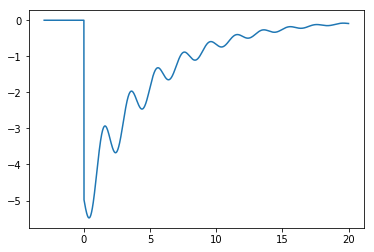

In [7]:
t = np.arange(-3,20,0.01)
plt.plot(t,y(t,1,np.pi,3.1,5))

In [8]:
t_sim     =  np.random.rand(40*len(t))*23-3
e_sim     =  np.random.normal(916,9,len(t_sim))
e_noisy   =  e_sim + np.random.normal(0,9,len(t_sim))
y_sim     =  (1+1e-1*y(t_sim,1,np.pi,3.1,5) +1e-1*np.random.normal(0,1,len(t_sim)))
IFEE_sim  =   np.random.normal(2,0.4,len(t_sim))
I0_sim    =  IFEE_sim*np.exp(-(913-e_noisy)**2/2**2)+1e-1*np.random.normal(0.0,0.2,len(t_sim))**2
I_sim     =  I0_sim*y_sim*(1+(e_sim-885)*1) +1e-2*np.random.normal(0,0.8,len(t_sim))**2

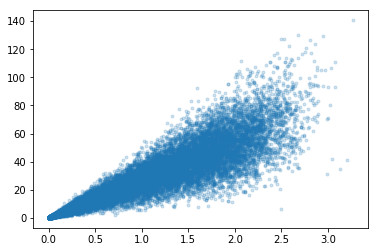

In [9]:
plt.plot(I0_sim,I_sim,'.',alpha=0.2)

/home/mouth_breather/anaconda3/envs/sympy_v1.1.1/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/mouth_breather/anaconda3/envs/sympy_v1.1.1/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(0, 9.742622156314289)

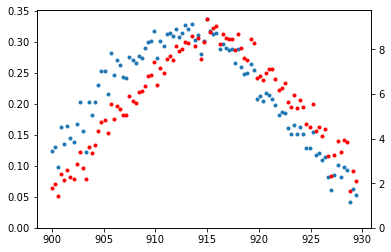

In [10]:
my_bins = np.arange(900,930,0.3)

my_binned_stat = binned_statistic_dd(e_sim,I0_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1)
plt.ylim(0,)
plt.twinx()
my_binned_stat = binned_statistic_dd(e_sim,I_sim,bins=[my_bins],statistic=np.average)
plt.plot(my_binned_stat.bin_edges[0][:-1],my_binned_stat.statistic,'.',alpha=1,color='r')
plt.ylim(0,)

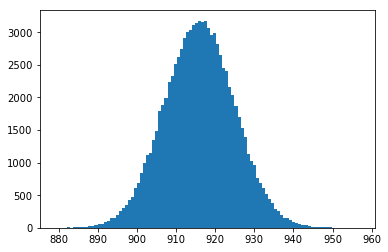

In [11]:
dummy_hist = plt.hist(e_sim,bins=100)

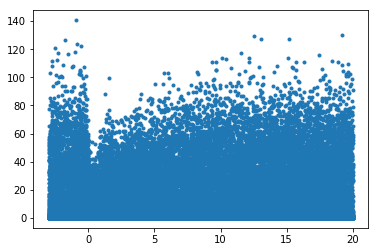

In [12]:
plt.plot(t_sim,I_sim,'.')
plt.show()

## global using scipy optimize

###  basic example

#### minimize

In [197]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
def some_other_function(x):
    """some other function"""
    return ((x[0]-100)**2+(x[1]-40)**2)

In [198]:
some_other_function(x0)

11286.18

In [199]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(some_other_function, x0, method='nelder-mead',
               options={'xtol': 1e-8, 'disp': True})


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 298
         Function evaluations: 518


In [200]:
res.x

array([ 100.        ,   40.        ,  -19.94796769, -131.62740087,
        -11.0342228 ])

#### fmin

In [218]:
def f(x):
    return (x[0]-3)**2+(x[1]-12)**2+(x[2]+3)**2

In [220]:
minimum = optimize.fmin(f, [1,2,3])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 105
         Function evaluations: 192


In [223]:
minimum

array([ 3.00000592, 12.00003628, -2.99997644])

### implementation

In [13]:
t_bins = np.arange(-3,20,0.1)

my_indices = np.digitize(t_sim,t_bins)


In [14]:
I0_sim.shape

(92000,)

In [15]:
def get_mean_squared_error(fit_params):
    offset  = fit_params[0]
    IvsI0_E = fit_params[1]
    IvsI0   = fit_params[2:]
    mean_squared_error = 0
    #I_sim     =  I0_sim*y_sim*(1+(e_sim-885)*1) +1e-2*np.random.normal(0,0.8,len(t_sim))**2
    #model   = symfit.Model({I:IvsI0[0]*I0*(1+IvsI0_E*energy) +offset})
    for i in range(len(t_bins)):
        #pint(i)
        my_mask = (my_indices==i)
        mean_squared_error += np.sum((IvsI0[i]*I0_sim[my_mask]*(1+IvsI0_E*e_sim[my_mask])+offset-I_sim[my_mask])**2)
  
    #mean_squared_error +=1e3*np.sum((np.diff(IvsI0[4:]))**2)
    return mean_squared_error
        

In [16]:
my_fit_params      = np.zeros(len(t_bins)+2)
my_fit_params[0]   = -1e-2
my_fit_params[1]   = 4e-2
my_fit_params[2]   = -2e-1
my_fit_params[3:]  = 1+np.random.rand(len(my_fit_params[3:]))+1e-1

In [17]:
get_mean_squared_error(my_fit_params)

37513291.15663884

In [18]:
callback_dict = {}
callback_dict['cached_results'] = 0
callback_dict['counter']        = 0
#callback_dict['fig']            = plt.figure()
#callback_dict['ax']             = callback_dict['fig'].add_subplot(111)



def monitoring_callback(x):
    global callback_dict
    callback_dict['cached_results'] = x
    callback_dict['counter']  = callback_dict['counter']  +1
    #if(callback_dict['counter'] >100):
        #plt.plot(t_bins,x[2:])
    #    callback_dict['line1'] = callback_dict['ax'].(t_bins,x[2:])
    #    plt.show()
    #    callback_dict['counter']  = 0
        
    #print(x)

In [19]:
#fit_results= optimize.fmin(get_mean_squared_error, my_fit_params,maxiter=1e2)

In [72]:
try:
    #fit_results= optimize.fmin(get_mean_squared_error, my_fit_params,maxiter=1e9,callback=monitoring_callback)
    fit_results= optimize.minimize(get_mean_squared_error,my_fit_params,method="CG", callback=monitoring_callback)
except KeyboardInterrupt:
    pass
my_fit_params = callback_dict['cached_results']
get_mean_squared_error(my_fit_params)
#fit_results= optimize.fmin(get_mean_squared_error, fit_results,maxiter=1e9,ftol=1e-12)

1165522.5699003174

In [73]:
callback_dict['counter']

10275

In [74]:
get_mean_squared_error(my_fit_params)

1165522.5699003174

In [70]:
get_mean_squared_error(my_fit_params)

2072688.5144720734

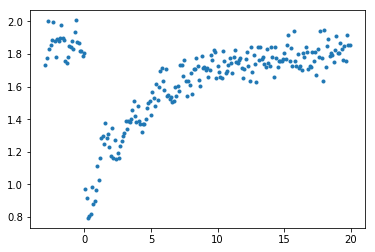

In [75]:
plt.plot(t_bins[1:],my_fit_params[3:],'.')
plt.show()

## global using symfit

### symfit example

In [85]:
xdata = np.arange(8,21,0.2)
ydata = 3.1* np.e**(-(xdata - 15)**2/(2 * 2**2))
ydata += np.random.rand(len(ydata))

In [86]:
print(xdata)
print(ydata)

[ 8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6
 10.8 11.  11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4
 13.6 13.8 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2
 16.4 16.6 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.
 19.2 19.4 19.6 19.8 20.  20.2 20.4 20.6 20.8]
[0.77152171 0.71345115 0.77917965 0.79971089 0.70988715 0.56151289
 0.829243   0.25344787 0.37125838 0.45912555 0.46267472 0.35685547
 0.54184327 1.08102294 0.62516366 1.05413466 0.52904174 0.78696373
 1.49637372 1.2975432  1.94411702 1.99880837 1.52488542 1.93454124
 1.78985694 2.6764484  2.96861776 2.40312007 3.23610683 3.27254929
 3.67947724 2.97383918 3.61730688 3.59277175 3.37063003 3.15133214
 3.18781864 3.46168971 3.69903002 3.46958503 3.4887305  3.07626827
 2.81238604 2.85161909 2.47100087 2.7021311  1.72145416 1.97162572
 2.01809017 1.83566003 1.34065596 1.46511117 1.55969947 1.34589519
 1.19181154 1.12364847 0.50281393 0.46621876 1.01003453 0.41474788


In [87]:
A = symfit.Parameter(name='A',value=4)
sig = symfit.Parameter(name='sig',value=4)
x0 = symfit.Parameter(name='x0',value=15)
x, y = symfit.variables('x, y')


# Gaussian distrubution
model =symfit.Model({y: A * symfit.exp(-(x0 - x)**2/(2 * sig**2))})

In [88]:
fit = symfit.Fit(model, x=xdata, y=ydata)
fit_result = fit.execute()

In [89]:
fit_result.params

OrderedDict([('A', 3.447883360711214),
             ('sig', 2.4916823992008563),
             ('x0', 14.99524407835496)])

In [90]:
y_predict = model(x=xdata, **fit_result.params)

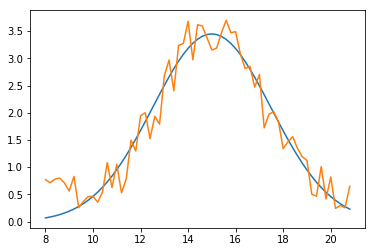

In [91]:
plt.plot(xdata,y_predict.y)
plt.plot(xdata,ydata)
#plt.plot(y,xdata)
plt.show()

### symfit global example

In [37]:
xdata = np.arange(8,21,0.2)
ydata = 3.1* np.e**(-(xdata - 15)**2/(2 * 2**2))
ydata += np.random.rand(len(ydata))

xdata2 = np.arange(12,28,0.2)
ydata2 = 6.3* np.e**(-(xdata2 - 21)**2/(2 * 2**2))
ydata2 += np.random.rand(len(ydata2))

In [38]:
A = symfit.Parameter(name='A',value=4)
A2 = symfit.Parameter(name='A2',value=4)
sig = symfit.Parameter(name='sig',value=4)
x0 = symfit.Parameter(name='x0',value=14)
x1 = symfit.Parameter(name='x1',value=22)
x, y = symfit.variables('x, y')
x2, y2 = symfit.variables('x2, y2')


In [39]:
model =symfit.Model({y: A * symfit.exp(-(x0 - x)**2/(2 * sig**2)),
                     y2: A2 * symfit.exp(-(x1 - x2)**2/(2 * sig**2))})

In [40]:
model.vars

[x, x2, y, y2, sigma_y, sigma_y2]

In [41]:
my_kwargs = {}
my_kwargs[str(model.vars[0])] = xdata
my_kwargs[str(model.vars[1])] = xdata2
my_kwargs[str(model.vars[2])] = ydata
my_kwargs[str(model.vars[3])] = ydata2

In [42]:
my_kwargs

{'x': array([ 8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. ,
        10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2,
        12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4,
        14.6, 14.8, 15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6,
        16.8, 17. , 17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8,
        19. , 19.2, 19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6, 20.8]),
 'x2': array([12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6, 13.8, 14. ,
        14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4, 15.6, 15.8, 16. , 16.2,
        16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6, 17.8, 18. , 18.2, 18.4,
        18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8, 20. , 20.2, 20.4, 20.6,
        20.8, 21. , 21.2, 21.4, 21.6, 21.8, 22. , 22.2, 22.4, 22.6, 22.8,
        23. , 23.2, 23.4, 23.6, 23.8, 24. , 24.2, 24.4, 24.6, 24.8, 25. ,
        25.2, 25.4, 25.6, 25.8, 26. , 26.2, 26.4, 26.6, 26.8, 27. , 27.2,
        27.4, 27.6, 27.8]),
 'y

In [11]:
#kwarg approach for putting full lists of data in global regression
fit = symfit.Fit(model, **my_kwargs)
fit_result = fit.execute()

In [287]:
#above as opposed to here whereit's done manually
#fit = symfit.Fit(model, x=xdata, y=ydata,x2=xdata2,y2=ydata2)
#fit_result = fit.execute()

In [12]:
fit_result.params

OrderedDict([('A', 3.602381527948849),
             ('A2', 6.461815371772701),
             ('sig', 2.297167598217253),
             ('x0', 15.00166540112712),
             ('x1', 20.973144260385578)])

In [13]:
y_predict = model(x=xdata,x2=xdata2, **fit_result.params)

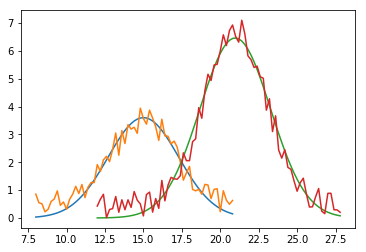

In [14]:
plt.plot(xdata,y_predict.y)
plt.plot(xdata,ydata)

plt.plot(xdata2,y_predict.y2)
plt.plot(xdata2,ydata2)

#plt.plot(y,xdata)
plt.show()

### symfit applied to non global case

In [175]:
t_bins = np.arange(-3,20,1)

In [176]:
energy  = symfit.Variable('energy')
I0      = symfit.Variable('I0')
I      = symfit.Variable('I')
offset  = symfit.Parameter(name='offset',value=0)
IvsI0_E = symfit.Parameter(name='IvsI0_E',value=0)
IvsI0   = [symfit.Parameter(name='IvsI0_bin'+str(i),value=45) for i in range(len(t_bins))]

In [177]:
#I_sim = I0_sim*y_sim *10* (1+(e_sim-895)/50.0) +np.random.normal(0,0.8,len(t_sim))**2
model   = symfit.Model({I:IvsI0[0]*I0*(1+IvsI0_E*energy) +offset})

In [178]:
fit = symfit.Fit(model,I0=I0_sim,energy=e_sim,I=I_sim)

In [179]:
fit_result = fit.execute()

In [180]:
fit_result.params

OrderedDict([('IvsI0_E', 0.9100996666869666),
             ('IvsI0_bin0', 0.03269602535052805),
             ('offset', 0.0042176913770013485)])

In [181]:
I_predict = model(I0=I0_sim,energy=e_sim, **fit_result.params)

In [182]:
I_predict.I

array([3.71934048e-02, 5.95980876e+01, 5.36574258e+01, ...,
       2.10874124e-01, 4.24443470e-03, 4.95316057e+01])

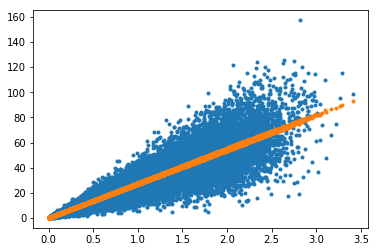

In [183]:
plt.plot(I0_sim,I_sim,'.')
plt.plot(I0_sim,I_predict.I,'.')
#plt.plot(y,xdata)
plt.show()

### Starting the global model development

In [131]:
energy  = [symfit.Variable(name='energy_bin'+str(i)) for i in range(len(t_bins))]
I0      = [symfit.Variable(name='I0_bin'+str(i)) for i in range(len(t_bins))]
I       = [symfit.Variable(name='I_bin'+str(i)) for i in range(len(t_bins))]
offset  = symfit.Parameter(name='offset',value=0)
IvsI0_E = symfit.Parameter(name='IvsI0_E',value=0)
IvsI0   = [symfit.Parameter(name='IvsI0_bin'+str(i),value=45) for i in range(len(t_bins))]

In [132]:
my_model_dict = {}
for i in range(len(I)):
    my_model_dict[I[i]] = IvsI0[i]*I0[i]*(1+IvsI0_E*energy[i]) +offset
model = symfit.Model(my_model_dict)

In [133]:
len(t_bins)


23

In [134]:
my_indices = np.digitize(t_sim,t_bins)

In [142]:
my_fit_kwargs = {}
for i in range(len(t_bins)):
    my_fit_kwargs["I0_bin"+str(i)] = I0_sim[my_indices==i+1] 
    my_fit_kwargs["energy_bin"+str(i)] = e_sim[my_indices==i+1]
    my_fit_kwargs["I_bin"+str(i)] = I_sim[my_indices==i+1]
    #my_fit_kwargs[model.vars[0]] = I0_sim
    #my_fit_kwargs[model.vars[1]] = e_sim
    #my_fit_kwargs

In [143]:
my_fit_kwargs.keys()

dict_keys(['I0_bin0', 'energy_bin0', 'I_bin0', 'I0_bin1', 'energy_bin1', 'I_bin1', 'I0_bin2', 'energy_bin2', 'I_bin2', 'I0_bin3', 'energy_bin3', 'I_bin3', 'I0_bin4', 'energy_bin4', 'I_bin4', 'I0_bin5', 'energy_bin5', 'I_bin5', 'I0_bin6', 'energy_bin6', 'I_bin6', 'I0_bin7', 'energy_bin7', 'I_bin7', 'I0_bin8', 'energy_bin8', 'I_bin8', 'I0_bin9', 'energy_bin9', 'I_bin9', 'I0_bin10', 'energy_bin10', 'I_bin10', 'I0_bin11', 'energy_bin11', 'I_bin11', 'I0_bin12', 'energy_bin12', 'I_bin12', 'I0_bin13', 'energy_bin13', 'I_bin13', 'I0_bin14', 'energy_bin14', 'I_bin14', 'I0_bin15', 'energy_bin15', 'I_bin15', 'I0_bin16', 'energy_bin16', 'I_bin16', 'I0_bin17', 'energy_bin17', 'I_bin17', 'I0_bin18', 'energy_bin18', 'I_bin18', 'I0_bin19', 'energy_bin19', 'I_bin19', 'I0_bin20', 'energy_bin20', 'I_bin20', 'I0_bin21', 'energy_bin21', 'I_bin21', 'I0_bin22', 'energy_bin22', 'I_bin22'])

In [144]:
"""my_kwargs = {}
my_kwargs[str(model.vars[0])] = xdata
my_kwargs[str(model.vars[1])] = xdata2
my_kwargs[str(model.vars[2])] = ydata
my_kwargs[str(model.vars[3])] = ydata2

#kwarg approach for putting full lists of data in global regression
fit = symfit.Fit(model, **my_kwargs)
fit_result = fit.execute()"""

'my_kwargs = {}\nmy_kwargs[str(model.vars[0])] = xdata\nmy_kwargs[str(model.vars[1])] = xdata2\nmy_kwargs[str(model.vars[2])] = ydata\nmy_kwargs[str(model.vars[3])] = ydata2\n\n#kwarg approach for putting full lists of data in global regression\nfit = symfit.Fit(model, **my_kwargs)\nfit_result = fit.execute()'

In [145]:
fit = symfit.Fit(model,**my_fit_kwargs)

In [147]:
fit_result = fit.execute()

In [151]:
fit_result.params

OrderedDict([('IvsI0_E', 323.6666732229522),
             ('IvsI0_bin0', 0.00010390808385608632),
             ('IvsI0_bin1', 0.00010346057346632257),
             ('IvsI0_bin10', 9.20922819920746e-05),
             ('IvsI0_bin11', 9.325283269434877e-05),
             ('IvsI0_bin12', 9.608883494913237e-05),
             ('IvsI0_bin13', 9.876509526135396e-05),
             ('IvsI0_bin14', 9.638607879841587e-05),
             ('IvsI0_bin15', 9.801560518982435e-05),
             ('IvsI0_bin16', 0.00010034196196508186),
             ('IvsI0_bin17', 9.980484309876915e-05),
             ('IvsI0_bin18', 0.0001008808738749131),
             ('IvsI0_bin19', 0.00010083576852542032),
             ('IvsI0_bin2', 0.00010342350673727782),
             ('IvsI0_bin20', 0.00010373760693025807),
             ('IvsI0_bin21', 0.00010316349373664714),
             ('IvsI0_bin22', 0.00010186280981148096),
             ('IvsI0_bin3', 5.165983171961125e-05),
             ('IvsI0_bin4', 7.086969899146417e-05),

In [172]:
IvsI0_list = []
for i in range(len(t_bins)):
    IvsI0_list.append(fit_result.params["IvsI0_bin"+str(i)])

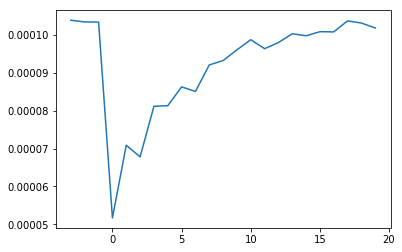

In [174]:
#global fitting is working, but just 20 bins takes over an hour.  This approach will not scale.  
#Maybe try brute force numpy matrix non-linear least squares and see if it's solvable.
plt.plot(t_bins,IvsI0_list)

## standard bin by bin regression

In [547]:
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

residuals = []

I_sim_size = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask]-np.mean(I0_sim[my_mask]),(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    #X = np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(I0_sim[my_mask])*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])
    beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    
    residuals.append(list((I_sim[my_mask]-np.dot(X.transpose(),np.array([beta]).transpose())[:,0])))
    I_sim_size = I_sim_size+I_sim[my_mask].shape[0]
    my_pump_probe.append(beta)

In [548]:
my_pump_probe = np.array(my_pump_probe)

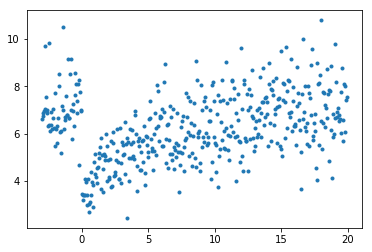

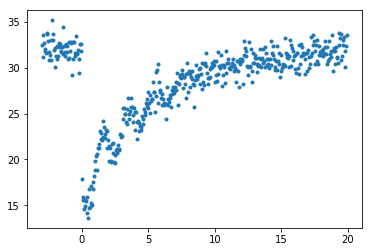

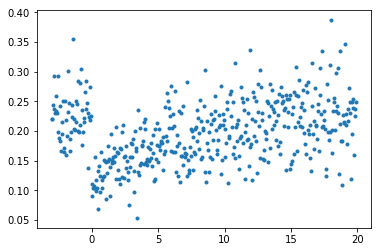

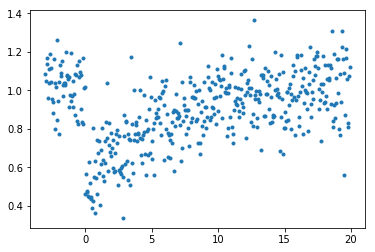

In [549]:
for i in range(X.shape[0]):
    plt.plot(t_bins[:-1],my_pump_probe[:,i],'.')
    plt.show()

## ridge regression

### making big matrix for linearized system


In [25]:
#make giant matrix
t_bins = np.arange(-3,20,0.05)

my_pump_probe = []

big_X = np.zeros([I_sim.shape[0],t_bins.shape[0]*4])
big_Y = np.zeros([I_sim.shape[0],t_bins.shape[0]])

my_col = 0
my_row = 0

my_ycol = 0
my_yrow = 0

for i in np.arange(len(t_bins)-1):
    my_mask  = (t_sim >= t_bins[i])
    my_mask *= (t_sim <= t_bins[i+1])
    
    X = (np.array([np.ones(np.sum(my_mask)),I0_sim[my_mask],(e_sim[my_mask]-np.mean(e_sim[my_mask])),(I0_sim[my_mask]-np.mean(I0_sim[my_mask]))*(e_sim[my_mask]-np.mean(e_sim[my_mask])) ])).transpose()
    Y = I_sim[my_mask]
    
    big_X[my_row:my_row+X.shape[0],my_col:my_col + X.shape[1]] = X
    big_Y[my_yrow:my_yrow+Y.shape[0],my_ycol] = Y
    
    my_col = my_col + X.shape[1]
    my_row = my_row + X.shape[0]
    
    my_ycol = my_ycol + 1
    my_yrow = my_yrow + Y.shape[0]

    
    #beta = np.dot(np.linalg.pinv(X.transpose()),I_sim[my_mask])
    #my_pump_probe.append(beta)

In [26]:
pseudo_inv = np.linalg.pinv(big_X)

## diagonal beta

In [27]:
beta = np.dot(pseudo_inv,big_Y)

In [28]:
beta.shape

(1840, 460)

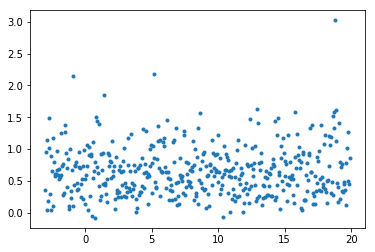

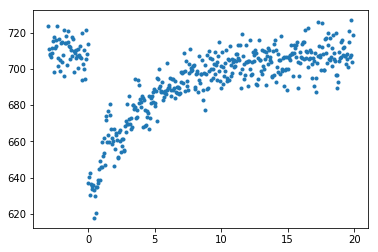

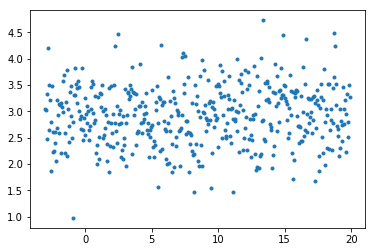

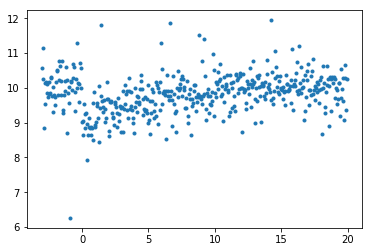

In [29]:
for i in range(4):
    plt.plot(t_bins[:-1],np.diag(beta[i::X.shape[1]][:-1]),'.')
    plt.show()

In [30]:
#now need to implement the tikhonov matrix to constrain standard dev of beta parameters that aren't pump probe
#related and use cross validation to tune them.

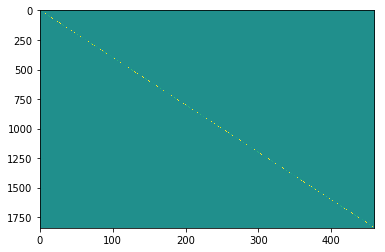

In [31]:
plt.imshow(beta,aspect='auto',clim=(-10,10))

In [32]:
#make ridge kernel
print(beta.shape)
print(big_Y.shape)
print(big_X.shape)

(1840, 460)
(9200, 460)
(9200, 1840)


In [33]:
gamma = 1*(+)

regularization_term = np.dot(np.linalg.inv(np.dot(gamma.transpose(),gamma)),big_X.transpose())


beta = np.dot(pseudo_inv,big_Y) + 

SyntaxError: invalid syntax (<ipython-input-33-01af5d75b94e>, line 1)